In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import random
import conditionalconformal
from conditionalconformal import CondConf
import itertools
import math
from numpy import sin, cos, exp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2

2024-04-19 23:54:38.031945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

dimension_z = 100
dimension_x = 100
number_z = 30
# Generating 30 vectors, each with 100 dimensions
z_domain = np.random.normal(size=(number_z, dimension_z))

# Generating beta_1 and beta_2
beta_1 = np.random.uniform(-1, 1, dimension_x)
beta_2 = np.random.uniform(-1, 1, dimension_z)


In [3]:

def generate_function(beta_1, beta_2):

    def function_2(X, Z):
        epsilon = np.random.uniform(-1, 1)

        T = exp(abs(np.dot(beta_1.T, X))/40)*(np.cos(np.dot(beta_2.T, Z))**2)  +1+ epsilon
        return T


    return function_2

function_2 = generate_function(beta_1, beta_2)


In [4]:
def phi_fn(feature):
    scalar_values = np.array(feature[:,dimension_x:(dimension_x+dimension_z)])#len 500

    # Initialize the indicator matrix
    matrix = np.zeros((len(np.array(feature[:,1])), number_z))

    # Fill in the indicator matrix
    for i, value in enumerate(scalar_values):
        for j in range(0, number_z):
            if  np.array_equal(value, z_domain[j]):
                matrix[i, j] = 1

    return matrix

In [5]:
# Function to combine X and Z into a single flattened array
flatten_features = lambda df: np.array([np.concatenate([x, z]) for x, z in zip(df['X'], df['Z'])])

In [6]:

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
var_x = 8
def conformal_predict_z_0(alpha=0.1, m=100, Z_new=Z_new, N=1000, t=200):
    IR = []
    for j in range(t):
        data_points = []
        for _ in range(N):
            # Randomly select a vector from z_domain to be Z
            Z = z_domain[np.random.randint(z_domain.shape[0])]

            # Compute the mean of the square of Z
            mean_x = np.mean(Z**2)

            # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 8
            X = np.random.normal(mean_x, var_x, dimension_x)

            # Compute T_1 the generated functions
            T_1 = function_2(X, Z)

            # Append the data point (X, Z, T_1) to the list
            data_points.append([X, Z, T_1])
        # Split the data into D_cali and D_train
        D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
        D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

        # Preparing data for regression
        X_train = flatten_features(D_train)
        # Extracting T_1 for D_train and D_cali
        Y_train = D_train['T_1'].values
        # Build a neural network model
        model_nn = Sequential([
            InputLayer(input_shape=(X_train.shape[1],)),   
            Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), # Use LeakyReLU and L2 regularization
            Dropout(0.3),
            Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
            Dense(1)               
        ])
 
        # Compilation model
        model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        # train the model on D train
        history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)
        
        score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
        condCovProgram = CondConf(score_fn, phi_fn, {})
        condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())
        
        data_points_new = []
        for _ in range(m):
            # Compute the mean of the square of Z
            mean_x_new = np.mean(Z_new**2)
            # Generate a 100-dimensional vector X from a normal distribution with mean mean_x_new and variance 1
            X_new = np.random.normal(mean_x_new, var_x, dimension_x)
            # Compute T_1 using the generated functions
            T_1_new = function_2(X_new, Z_new)

            # Append the data point (X, Z, T_1) to the list
            data_points_new.append([X_new, Z_new, T_1_new])

        # Split the data into D_cali and D_train
        D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])
        
        X_neww = flatten_features(D_new)
        T_1_new= D_new['T_1']
        T_1_pred_new = model_nn.predict(X_neww).flatten()

        Xtest = np.array([flatten_features(D_new)[10,:]])
        d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
        
        # Calculate intervals
        hat_t_L = T_1_pred_new - d
        hat_t_U = T_1_pred_new + d 
        IR.append(np.mean((hat_t_L <= T_1_new) & (T_1_new <= hat_t_U)))
             
    return IR, d

In [7]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]

IR, d = conformal_predict_z_0(alpha=0.1, m=50, Z_new=Z_new, N=10000, t=1000)

/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

Text(0, 0.5, 'Coverage')

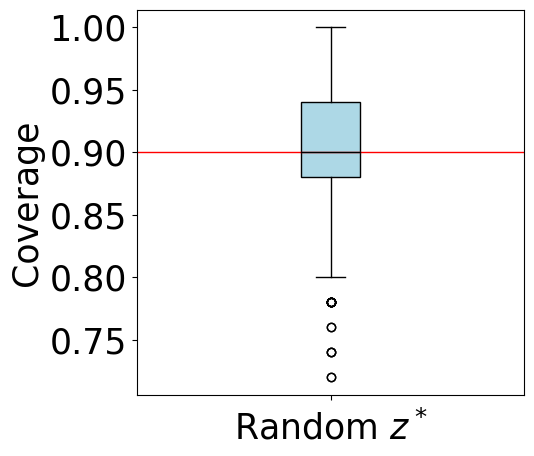

In [10]:
fig = plt.figure(figsize=(5, 5))
plt.boxplot(IR, patch_artist=True, medianprops=dict(color="black"), boxprops=dict(facecolor='lightblue'))
plt.yticks( fontsize=25)
plt.xticks([1], [''])  # Setting x-axis label to an empty string
plt.axhline(y=0.9, color='red', linestyle='-', label='', linewidth=1)
plt.xlabel('Random $z^*$', fontsize=25)
plt.ylabel('Coverage', fontsize=25)

In [17]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]


def conformal_predict(alpha=0.1, m=100, Z_new=Z_new, N=1000):
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]

        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)

        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 8
        X = np.random.normal(mean_x, var_x, dimension_x)

        # Compute T_1 using the generated functions
        T_1 = function_2(X, Z)

        # Append the data point (X, Z, T_1) to the list
        data_points.append([X, Z, T_1])
    # Split the data into D_cali and D_train
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

    # Preparing data for regression
    X_train = flatten_features(D_train)
    # Extracting T_1 for D_train and D_cali
    Y_train = D_train['T_1'].values
    # Build a neural network model
    model_nn = Sequential([
        InputLayer(input_shape=(X_train.shape[1],)),   
        Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), # Use LeakyReLU and L2 regularization
        Dropout(0.3),
        Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
        Dense(1)                       # Output layer
    ])

    # Compilation model
    model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # train the model on D train
    history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)
     
        
    
    score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 8
        X_new = np.random.normal(mean_x_new, var_x, dimension_x)
        # Compute T_1 using the generated functions
        T_1_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = flatten_features(D_new)
    T_1_new= D_new['T_1']
    T_1_pred_new = model_nn.predict(X_neww).flatten()

    Xtest = np.array([flatten_features(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) >= reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

In [20]:
m_0 = 50
IR_compare = []
ratio = []
Pay = []
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]

np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

for i in range(1000):
    result = conformal_predict(alpha=0.1, m=m_0,  Z_new=Z_new, N = 10000)
    IR_compare.append(result[2])
    ratio.append(result[1])
    Pay.append(result[0])


/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 

(-0.75, 1.0)

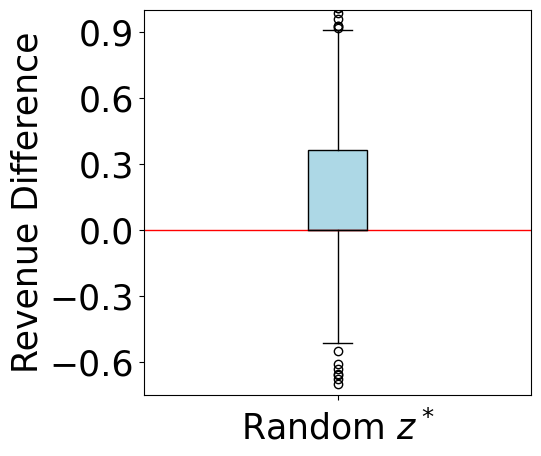

In [35]:
fig = plt.figure(figsize=(5, 5))

plt.xlabel('Random $z^*$', fontsize=25)
plt.ylabel('Revenue Difference', fontsize=25)
plt.boxplot(IR_compare, patch_artist=True, boxprops=dict(facecolor='lightblue'),  # Box color set to blue
            medianprops=dict(color="black"))
plt.yticks([-0.6,-0.3,0,0.3,0.6,0.9], fontsize=25)
plt.xticks([1], [''])  # Setting x-axis label to an empty string
plt.axhline(y=0, color='red', linestyle='-', label='', linewidth=1)
plt.ylim(-0.75,1)

In [13]:
var = 8
def conformal_predict(alpha=0.1, m=100, Z_new=Z_new):

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x_new and variance 8
        X_new = np.random.normal(mean_x_new, var, dimension_x)
        # Compute T_1  using the generated functions
        T_1_new = function_2(X_new, Z_new)
        
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = flatten_features(D_new)
    T_1_new= D_new['T_1']
    T_1_pred_new = model_nn.predict(X_neww).flatten()

    Xtest = np.array([flatten_features(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) >= reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

In [14]:
np.random.seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]


np.random.seed(0)
random.seed(0)
tf.random.set_seed(1)
# Set different values for N
N_values = [1000, 3000, 5000, 7000, 9000, 11000, 13000]
num_runs = 1000

# Initializes the dictionary used to store the results
results = {"payment": [], "sb_value": [], "max_welfare": []}

# For each value of N, run the function 200 times and calculate the average
for N in N_values:
    data_points = []
    for _ in range(N):
        # Randomly select a vector from z_domain to be Z
        Z = z_domain[np.random.randint(z_domain.shape[0])]

        # Compute the mean of the square of Z
        mean_x = np.mean(Z**2)

        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 8
        X = np.random.normal(mean_x, var, dimension_x)

        # Compute T_1 using the generated functions
        T_1 = function_2(X, Z)

        # Append the data point (X, Z, T_1) to the list
        data_points.append([X, Z, T_1])
    # Split the data into D_cali and D_train
    D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
    D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

    # Preparing data for regression
    X_train = flatten_features(D_train)
    # Extracting T_1 for D_train and D_cali
    Y_train = D_train['T_1'].values
    model_nn = Sequential([
        InputLayer(input_shape=(X_train.shape[1],)),   
        Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), 
        Dropout(0.3),
        Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
        Dense(1)                        
    ])

    model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)
    score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
    condCovProgram = CondConf(score_fn, phi_fn, {})
    condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())
    
    payments, sb_values, max_welfares = [], [], []
    for _ in range(num_runs):
        payment, _, _, sb_value, max_welfare = conformal_predict(0.1, 50, Z_new)
        payments.append(payment)
        sb_values.append(sb_value)
        max_welfares.append(max_welfare)
    results["payment"].append(np.mean(payments))
    results["sb_value"].append(np.mean(sb_values))
    results["max_welfare"].append(np.mean(max_welfares))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


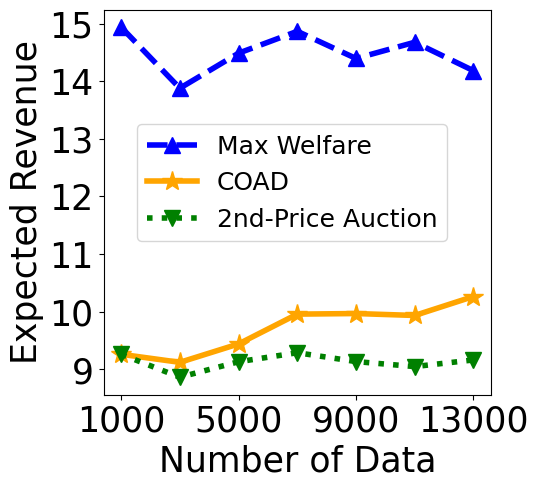

In [24]:
plt.figure(figsize=(5,5)) 
plt.plot(N_values, results["max_welfare"], label="Max Welfare", color='blue', linestyle='--', marker='^', linewidth=4,markersize=12)
plt.plot(N_values, results["payment"], label="COAD", color='orange', linestyle='-', marker='*', linewidth=4,markersize=15)
plt.plot(N_values, results["sb_value"], label="2nd-Price Auction", color='green', linestyle=':', marker='v', linewidth=4,markersize=12)

plt.xlabel("Number of Data", fontsize=25)
plt.ylabel("Expected Revenue", fontsize=25)
plt.legend(fontsize=18, bbox_to_anchor=(0.919, 0.55))
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.xticks([1000,5000, 9000,13000])
plt.show()

In [13]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
var_x = 8
data_points = []
N = 20000
for _ in range(N):
    # Randomly select a vector from z_domain to be Z
    Z = z_domain[np.random.randint(z_domain.shape[0])]

    # Compute the mean of the square of Z
    mean_x = np.mean(Z**2)

    # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 8
    X = np.random.normal(mean_x, var_x, dimension_x)

    # Compute T_1 using the generated functions
    T_1 = function_2(X, Z)

    # Append the data point (X, Z, T_1) to the list
    data_points.append([X, Z, T_1])
# Split the data into D_cali and D_train
D_cali = pd.DataFrame(data_points[:N//2], columns=["X", "Z", "T_1"])
D_train = pd.DataFrame(data_points[N//2:], columns=["X", "Z", "T_1"])

# Preparing data for regression
X_train = flatten_features(D_train)
# Extracting T_1 for D_train and D_cali
Y_train = D_train['T_1'].values
# Build a neural network model
model_nn = Sequential([
    InputLayer(input_shape=(X_train.shape[1],)),   
    Dense(128, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)), # Use LeakyReLU and L2 regularization
    Dropout(0.3),
    Dense(64, activation=LeakyReLU(alpha=0.01), kernel_regularizer=l2(0.02)),
    Dense(1)                    
])

model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

history = model_nn.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=0)

score_fn = lambda feature,  y : abs(y - model_nn.predict(feature).flatten())
condCovProgram = CondConf(score_fn, phi_fn, {})
condCovProgram.setup_problem(flatten_features(D_cali),D_cali['T_1'].to_numpy())

def conformal_predict(alpha=0.1, m=100, Z_new=Z_new):

    data_points_new = []
    for _ in range(m):
        # Compute the mean of the square of Z
        mean_x_new = np.mean(Z_new**2)
        # Generate a 100-dimensional vector X from a normal distribution with mean mean_x and variance 8
        X_new = np.random.normal(mean_x_new, var_x, dimension_x)
        # Compute T_1 using the generated functions
        T_1_new = function_2(X_new, Z_new)

        # Append the data point (X, Z, T_1) to the list
        data_points_new.append([X_new, Z_new, T_1_new])

    # Split the data into D_cali and D_train
    D_new = pd.DataFrame(data_points_new, columns=["X", "Z", "T_1"])

    X_neww = flatten_features(D_new)
    T_1_new= D_new['T_1']
    T_1_pred_new = model_nn.predict(X_neww).flatten()

    Xtest = np.array([flatten_features(D_new)[10,:]])
    d = condCovProgram.predict(1-alpha, Xtest, lambda x, y : x)
     
    reserve_price = T_1_pred_new - d
    virtual_value = np.array(T_1_new) * (np.array(T_1_new) >= reserve_price)

    # Find the index(es) of the maximum virtual value
    max_virtual_value_indexes = np.where(virtual_value == np.max(virtual_value))[0]
    winner = None
    if len(max_virtual_value_indexes) > 1:
    # Check the reserve price for the max virtual value indexes
        max_reserve_price_indexes = np.where(reserve_price[max_virtual_value_indexes] == np.max(reserve_price[max_virtual_value_indexes]))[0]

        if len(max_reserve_price_indexes) > 1:
        # If multiple maximums, choose one at random
            winner = np.random.choice(max_virtual_value_indexes[max_reserve_price_indexes])
        else:
        # If only one maximum
            winner = max_virtual_value_indexes[max_reserve_price_indexes[0]]
    else:
    # If only one maximum virtual value
        winner = max_virtual_value_indexes[0]

    sorted_virtual_value = np.sort(virtual_value)[::-1]
    payment = max(0, sorted_virtual_value[1], reserve_price[winner])
    max_welfare = np.max(np.array(T_1_new))
    
    return payment, payment/max_welfare, payment - np.sort(np.array(T_1_new))[::-1][1], np.sort(np.array(T_1_new))[::-1][1], max_welfare

/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/u/home/j/jialehan/.local/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


In [14]:
m_values = list(range(50, 301, 50))

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)
Z_new = z_domain[np.random.randint(z_domain.shape[0])]
num_runs = 1000

results_m = {"payment": [], "y_value": [], "max_welfare": []}

# For each m value, run the function 1000 times and calculate the average
for m in m_values:
    payments, y_values, max_welfares = [], [], []
    for _ in range(num_runs):
        payment, _, _, y_value, max_welfare = conformal_predict(0.1, m, Z_new)
        payments.append(payment)
        y_values.append(y_value)
        max_welfares.append(max_welfare)
    results_m["payment"].append(np.mean(payments))
    results_m["y_value"].append(np.mean(y_values))
    results_m["max_welfare"].append(np.mean(max_welfares))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
4/

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
4/4 ━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/s

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 895

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
10/10 ━━━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step
10/10 ━━━━━━━━━━

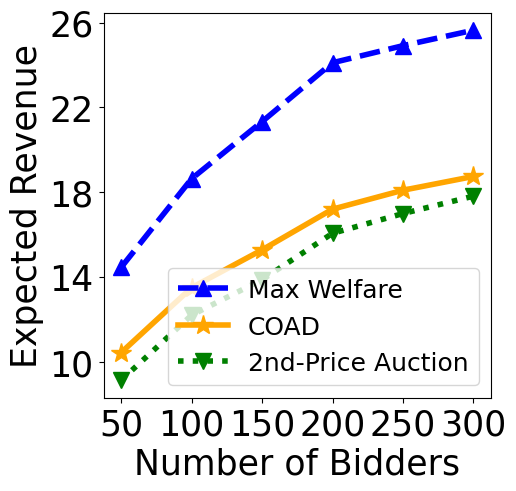

In [27]:
plt.figure(figsize=(5, 5))
plt.plot(m_values, results_m["max_welfare"], label="Max Welfare",color='blue', linestyle='--', marker='^', linewidth=4,markersize=12)
plt.plot(m_values, results_m["payment"], label="COAD",  color='orange', linestyle='-', marker='*', linewidth=4,markersize=15)
plt.plot(m_values, results_m["y_value"], label="2nd-Price Auction",  color='green', linestyle=':', marker='v', linewidth=4,markersize=12)

plt.xlabel("Number of Bidders", fontsize=25)
plt.ylabel("Expected Revenue", fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.yticks([10, 14,18,22,26])
plt.title("")
plt.legend(fontsize=18, loc="lower right")
plt.show()